In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.8

env: XLA_PYTHON_CLIENT_MEM_FRACTION=.8


In [3]:
import jax
jax.devices()

[CpuDevice(id=0)]

In [4]:
import sys
sys.path.insert(0, "/home/ninarell/OneDrive/WF_GAN_FOR_GLASSES/B_GEN/flow_diagrams")
import flow_diagrams

In [5]:
import jax
import time
import equinox as eqx
import numpy as np
import matplotlib.pyplot as plt
from jax import numpy as jnp
from IPython.display import clear_output
from jax import Array
# from openmm import unit
import optax
from flow_diagrams.utils.conditioning import convert_from_reduced_p, convert_from_reduced_t
from matplotlib import colors



In [6]:
jax.devices()

[CpuDevice(id=0)]

In [7]:
from jax_md import space, partition

In [8]:
from flow_diagrams.utils.train import log_weights_given_latent, normalize_weights, sampling_efficiency, effective_sample_size, delta_f_to_prior
from flow_diagrams.utils.visualization import radial_distribution_function
from flow_diagrams.utils.data import NumpyLoader, split_data
from flow_diagrams.utils.symmetry import *

from jax import numpy as jnp

#from flow_diagrams.energy.lennard_jones import fd_lennard_jones_neighbor_list
from jax_md.energy import stillinger_weber_neighbor_list

from flow_diagrams.models.coupling_flows import ConditionalCouplingFlowNPT

from flow_diagrams.utils.train import running_average
# from flow_diagrams.utils.lattice import volume_to_box
from flow_diagrams.utils.weights import get_weights, get_biases
from flow_diagrams.utils.jax import key_chain
from IPython.display import clear_output
from flow_diagrams.utils.conditioning import grid_conditional_variables
import time


2024-10-11 17:17:31.529416: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-11 17:17:31.529490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-11 17:17:31.567889: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-11 17:17:32.491228: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:
chain = key_chain(1)

## Constants

In [10]:
EPSILON   = 6.189
SIGMA     = 2.3925
a         = 1.80
lam       = 23.15
gamma     = 1.20
A         = 7.049556277
B         = 0.6022245584
p         = 4.
q         = 0.
#theta_0   = np.radians(109.47)
NUM_PARTICLES = 60 #180
SPATIAL_DIMENSIONS = 3
KB = 0.00831446261815324 # in (unit.kilojoule_per_mole/unit.kelvin)
CUTOFF= a * SIGMA

## Transformation functions

In [11]:

def remove_disp_of_first_atom(displacements):
    # assert displacements.shape == (NUM_PARTICLES, SPATIAL_DIMENSIONS)

    disp_at_1 = displacements[0,:]

    return displacements - disp_at_1


def transform_abs_coords_to_rel_coords(absolute_coordinates: Array, side_length: Array):
    """Transforms relative coordinates inside the unit cube to absolute coordinates given a 3d box_vector."""
    assert absolute_coordinates.shape[-1] == SPATIAL_DIMENSIONS
    assert side_length.shape == (3,)
    return absolute_coordinates / side_length






## Put MD data into dataloader 

In [12]:
def wrap_to_unit_cube(pos, lower, upper):
    width = upper - lower
    return jnp.mod(pos - lower, width) + lower

def wrap_to_box(pos, box):
    return pos % box

In [13]:
jax.config.update("jax_enable_x64", False)


In [14]:
LOWER = 0.
UPPER = 1.
CUT_TYPE = 'switch'

PRIOR_PRESSURE = 1.
TEMP_PRIOR  = 273.

REDUCED_TEMP_PRIOR = TEMP_PRIOR * KB / EPSILON
REDUCED_PRESS_PRIOR = PRIOR_PRESSURE * SIGMA**3 / EPSILON

filename_prior = f"prod.liquid_{TEMP_PRIOR:.0f}K_{PRIOR_PRESSURE:.0f}atm_mW.npz"

data_prior = jnp.load(filename_prior)
positions_prior_abs = data_prior['pos']
box_prior = data_prior['box']
vols_prior = jnp.prod(box_prior,axis=-1)
BOX_EDGES = np.mean(box_prior,axis=0)

# fix first atom in origin and wrap to box
positions_prior = jax.vmap(wrap_to_box)(jax.vmap(remove_disp_of_first_atom)(positions_prior_abs),box_prior)
MEAN_CONFIG = np.mean(positions_prior,axis=0)

# scale to [0,1]
positions_prior= jax.vmap(transform_abs_coords_to_rel_coords)(positions_prior,box_prior)
positions_prior = wrap_to_unit_cube(positions_prior,LOWER,UPPER)    

scale_prior = box_prior[:,0] / BOX_EDGES[0]
energies_prior = data_prior['ene']

assert np.logical_and(1. >= UPPER, positions_prior >= LOWER).all()
assert np.allclose(positions_prior[:,0,:],0,atol=1e-7)

n_configurations_prior = positions_prior.shape[0] 

print('# Prior samples', n_configurations_prior)

# Prior samples 10000


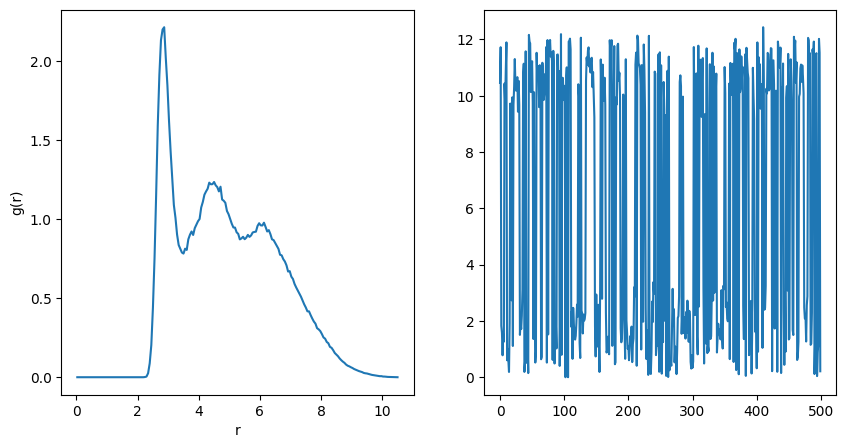

In [15]:
n_samples_rdf = 500
rdf = radial_distribution_function(data_prior['pos'][:n_samples_rdf],data_prior['box'][:n_samples_rdf], NUM_PARTICLES)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(*rdf)
plt.ylabel('g(r)')
plt.xlabel('r')
plt.subplot(1,2,2)
plt.plot(data_prior['pos'][:n_samples_rdf,0,0])
plt.show()

In [16]:
BATCH_SIZE = 128


In [17]:
train_fraction = .8
# Store all displacements relative to first one (which stays at its equilibrium position)
dataset_prior_train, dataset_prior_test = split_data(train_fraction, positions_prior,
                        energies_prior,
                       scale_prior)
dataloader_train = NumpyLoader(dataset_prior_train,BATCH_SIZE,False)



In [18]:
len(dataset_prior_train), len(dataset_prior_test)

(8000, 2000)

## Prepare the system

In [19]:

# Using float32 for positions / velocities, but float64 for reductions.
dtype = np.float32

# Specify the format of the neighbor list. 
# Options are Dense, Sparse, or OrderedSparse. 
format = partition.Dense #OrderedSparse

In [20]:
displacement_frac, shift_frac = space.periodic_general(BOX_EDGES, fractional_coordinates=False)

neighbor_fn, energy_fn = stillinger_weber_neighbor_list(
    displacement=displacement_frac,
    box_size=BOX_EDGES,
    sigma=SIGMA,
    A = A,
    B = B,
    lam = lam,
    gamma = gamma,
    epsilon= EPSILON,
    cutoff = CUTOFF,
    dr_threshold= 0.5,
    fractional_coordinates=False,
    format = format
    ) 

NEIGHBOR_LIST = neighbor_fn.allocate(MEAN_CONFIG)

In [21]:
def compute_sw_energy(pos_rel: jnp.ndarray, scale):
    box= scale * BOX_EDGES
    nbrs = NEIGHBOR_LIST.update(pos_rel * box)
    sw_energy = energy_fn(pos_rel * box, nbrs, box=box)

    return sw_energy


In [22]:
num_samples = 10


In [23]:
ene_prior = dataset_prior_test.energies[:num_samples]
pos_latent = dataset_prior_test.pos[:num_samples]
scale_latent = dataset_prior_test.scale[:num_samples]
# config_latent = jax.vmap(transform_abs_pos_to_abs_config)(pos_latent)
energies_recomputed_prior = jax.vmap(
               compute_sw_energy)(pos_latent,scale_latent)

/home/ninarell/miniconda3/envs/bg/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:212: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


In [24]:
print(len(positions_prior[1]))
print(energies_recomputed_prior - ene_prior)

60
[ 6.1035156e-05  1.2207031e-04 -1.8310547e-04  1.2207031e-04
 -6.1035156e-05  6.1035156e-05 -6.1035156e-05  0.0000000e+00
 -1.2207031e-04 -1.8310547e-04]


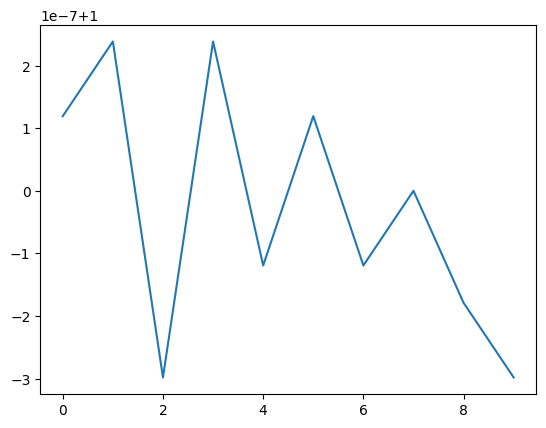

In [25]:
# Ensure that energy function reproduces the MD energies
plt.plot(ene_prior / energies_recomputed_prior)
plt.show()

In [26]:
chain=key_chain(1)

In [27]:
print(REDUCED_TEMP_PRIOR, REDUCED_PRESS_PRIOR)

0.36675525848373475 2.212765322043141


In [28]:
p_max = 2.4* convert_from_reduced_p(EPSILON, SIGMA)
p_min = 2.* convert_from_reduced_p(EPSILON, SIGMA)

t_max = 0.38* convert_from_reduced_t(EPSILON, KB)
t_min = 0.35* convert_from_reduced_t(EPSILON, KB)
conditioning_states= grid_conditional_variables(t_min,t_max,p_min, p_max, 80,80)



In [29]:
assert conditioning_states[0,0] == t_min
assert conditioning_states[0,1] == p_min

assert conditioning_states[-1,0] == t_max
assert conditioning_states[-1,1] == p_max

In [30]:
print(t_min, t_max, p_min, p_max)

260.527961875801 282.85893003658396 0.9038464133888876 1.084615696066665


In [31]:


flow = ConditionalCouplingFlowNPT(n_layers=1,
                            num_hidden=2,
                            dim_hidden=32,
                            num_hidden_shape=4,
                            dim_hidden_shape=16,
                            dim_embedd =32,
                            lower=0,
                            upper=1,
                            n_bins=16,
                            n_heads=1,
                            t_max=t_max,
                            p_max=p_max,
                            use_layer_norm=True,
                            n_blocks=1,
                            use_circular_shift=True,
                            n_freqs=8,
                            init_identity=True,
                            n_particles=NUM_PARTICLES ,
                            key= next(chain))

params, static = eqx.partition(flow, eqx.is_array)

param_count = sum(x.size for x in jax.tree_util.tree_leaves(params))
print(f"{param_count:_}")

156_587


## Train model

In [32]:
NUM_EPOCHS = 20
n_batches = len(dataloader_train)
n_total_steps = NUM_EPOCHS * n_batches


In [33]:
# optim = optax.adam(1e-7)
optim = optax.adam(5e-5
                   )
optim = optax.chain(optax.clip_by_global_norm(1e4), optim)

In [34]:
params, static = eqx.partition(flow, eqx.is_array)
opt_state = optim.init(params)


In [35]:
key = key_chain(1)


In [36]:
loss_batch_eval = jnp.zeros((n_batches,))
losses_eval = jnp.empty(shape=(0,))
efficiencies = jnp.empty(shape=(0,))


In [37]:
from flow_diagrams.train.train import make_step, batch_loss_temp_press_vmap

In [38]:
@eqx.filter_jit
def evaluate_flow(flow,pos,scale,temp,press):
    return flow.forward(pos=pos,scale=scale,temp=temp,press=press)

In [39]:
eval_state = jnp.array([[0.37 * EPSILON / KB, 2.212765322043141 * EPSILON / SIGMA**3]])


In [40]:
eval_state

Array([[275.41528,   1.     ]], dtype=float32)

In [41]:
# Reference value: Free energy difference per particle for evaluation state
delta_f_ref = -0.1391

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


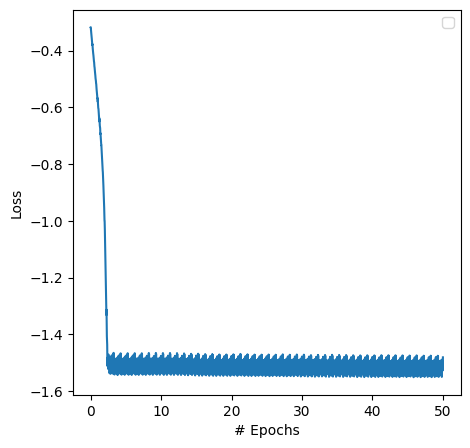

In [42]:
PRINT_ITERS = 5
IS_LIQUID = False
for i in range(NUM_EPOCHS):

    for ibatch, (batch_pos, batch_ene, batch_scale) in enumerate(dataloader_train):
        key = next(chain)
        chain = key_chain(key)

        loss_train, flow, opt_state = make_step(
            batch_pos=batch_pos,
            batch_ene=batch_ene,
            batch_scale=batch_scale,
            flow=flow,
            temps_and_pressures=conditioning_states,
            optimized_state=opt_state,
            optim=optim,
            target_energy_fn=compute_sw_energy,
            prior_pressure=PRIOR_PRESSURE,
            reference_box=BOX_EDGES,
            prior_temp=TEMP_PRIOR,
            key=next(chain),
        )

        loss_eval = batch_loss_temp_press_vmap(
            batch_pos=batch_pos,
            batch_scale=batch_scale,
            batch_ene=batch_ene,
            temps_and_pressures=eval_state,
            flow=flow,
            prior_pressure=PRIOR_PRESSURE,
            reference_box=BOX_EDGES,
            prior_temp=TEMP_PRIOR,
            target_energy_fn=compute_sw_energy,
        )

        loss_batch_eval = loss_batch_eval.at[ibatch].set(loss_eval)

    losses_eval = jnp.concatenate((losses_eval, loss_batch_eval))
    clear_output(wait=True)
    plt.figure(figsize=(5, 5))
    plt.plot(
        np.linspace(0, losses_eval.shape[0] / n_batches, losses_eval.shape[0]),
        losses_eval / NUM_PARTICLES,
    )

    #plt.axhline(delta_f_ref, linestyle="--", color="black", label=r"MBAR $\Delta f / N$")
    plt.xlabel("# Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

## Evaluate trained model 

In [43]:
evaluation_states = grid_conditional_variables(t_min,t_max,p_min, p_max, 8,8)


In [44]:
n_test = 200
batch_pos = dataset_prior_test.pos[:n_test]
batch_scale = dataset_prior_test.scale[:n_test]
batch_energies = dataset_prior_test.energies[:n_test]
efficiencies = jnp.empty((0,))
deltaFs = jnp.empty((0,))

mean_disps = jnp.empty((0,n_test))

for j, state in enumerate(evaluation_states):
    logw_flow_unnormalized = jax.vmap(
            lambda pos,ene,scal: log_weights_given_latent(
                pos_prior=pos,
                prior_energy=ene,
                scale_prior=scal,
                flow=flow,
                temp_and_pressure_target=state,
                temp_and_pressure_flow=state,
                n_particles=NUM_PARTICLES,
                pressure_prior=PRIOR_PRESSURE,
                temp_prior=TEMP_PRIOR,
                reference_box=BOX_EDGES,
                target_energy_fn=compute_sw_energy,
            )
        )(batch_pos, batch_energies, batch_scale)

    logw_normalized = normalize_weights(logw_flow_unnormalized)

    deltaF = delta_f_to_prior(logw_flow_unnormalized)

    efficiency = sampling_efficiency(logw_flow_unnormalized)
    ess_flow = effective_sample_size(logw_flow_unnormalized)
    efficiencies = jnp.concatenate((efficiencies, jnp.array([ efficiency])))
    deltaFs = jnp.concatenate((deltaFs, jnp.array([ deltaF])))
    print(j, state, efficiency)

0 [260.52795      0.90384644] 0.030906642
1 [260.52795      0.92967063] 0.03467353
2 [260.52795     0.9554948] 0.038225222
3 [260.52795      0.98131895] 0.04220378
4 [260.52795     1.0071431] 0.046628088
5 [260.52795     1.0329673] 0.05089738
6 [260.52795     1.0587915] 0.055101775
7 [260.52795     1.0846157] 0.060966983
8 [263.7181       0.90384644] 0.030180557
9 [263.7181       0.92967063] 0.034434687
10 [263.7181      0.9554948] 0.03814714
11 [263.7181       0.98131895] 0.041935455
12 [263.7181      1.0071431] 0.04597704
13 [263.7181      1.0329673] 0.04976426
14 [263.7181      1.0587915] 0.05330196
15 [263.7181      1.0846157] 0.058296118
16 [266.90823      0.90384644] 0.029042076
17 [266.90823      0.92967063] 0.03404338
18 [266.90823     0.9554948] 0.037994944
19 [266.90823      0.98131895] 0.041630067
20 [266.90823     1.0071431] 0.045350995
21 [266.90823     1.0329673] 0.048763398
22 [266.90823     1.0587915] 0.051924806
23 [266.90823     1.0846157] 0.056217704
24 [270.09836   

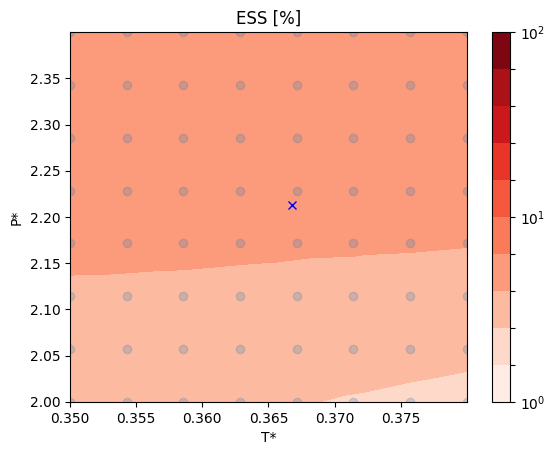

In [46]:
contour = plt.tricontourf(
    evaluation_states[:, 0]/ convert_from_reduced_t(EPSILON, KB),
    evaluation_states[:, 1] / convert_from_reduced_p(EPSILON, SIGMA),
    efficiencies * 100,
    norm=colors.LogNorm(),
    levels=np.geomspace(1e-0, 100, 11),
)
plt.colorbar(contour, ticks=np.geomspace(1e-0, 100, 11))
plt.scatter(
    evaluation_states[:, 0] / convert_from_reduced_t(EPSILON, KB),
    evaluation_states[:, 1] / convert_from_reduced_p(EPSILON, SIGMA),
    alpha=0.2,
)
plt.plot(REDUCED_TEMP_PRIOR, REDUCED_PRESS_PRIOR, "x", color="blue")
#plt.plot(TEMP_PRIOR, PRIOR_PRESSURE, "x", color="blue")
# plt.yscale('log')
plt.set_cmap("Reds")
plt.xlabel("T*")
plt.title("ESS [%]")
plt.ylabel("P*")
#plt.axis([0.3,0.4,1.8,2.5])
plt.show()

In [172]:
n_test = 100
batch_pos = dataset_prior_test.pos[:n_test]
batch_scale = dataset_prior_test.scale[:n_test]
batch_energies = dataset_prior_test.energies[:n_test]

results =jax.vmap(lambda pos,scale : evaluate_flow(flow,pos,scale,TEMP_PRIOR,PRIOR_PRESSURE))(batch_pos, batch_scale)

pos_results = jnp.array(results[0])
scale_results = jnp.array(results[1])
ene_results = jax.vmap(compute_sw_energy)(pos_results,scale_results)


In [176]:
compute_sw_energy(dataset_prior_test.pos[0],dataset_prior_test.scale[1])

Array(-607.60046, dtype=float32)

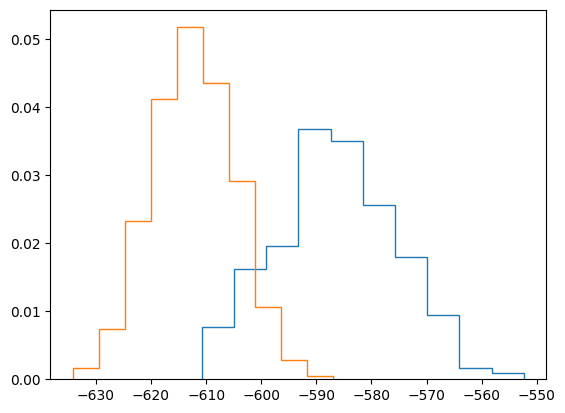

In [169]:
counts, bins = jnp.histogram(ene_results,density=1)
plt.stairs(counts, bins)
counts, bins = jnp.histogram(dataset_prior_test.energies,density=1)
plt.stairs(counts, bins)

